## Motivation

Building attributes such as building height, type, and construction year are not available for all buildings in EUBUCCO. However, for many prospective use cases of the dataset, such as energy modeling, the building attributes are of high importance. This notebook shows how the available building footprints can be used to estimate missing building attributes with supervised machine learning.

In [1]:
# -.-|m { input: false }

# standard libs
import os
import sys
import logging
import gc

# project lib
PROJECT_SRC_PATH = os.path.join( '/workspace/workspace/ufo-prediction', 'src')
sys.path.append(PROJECT_SRC_PATH)

import visualizations
from prediction_age import AgePredictor, AgeClassifier, AgePredictorComparison
import preprocessing as pp
import dataset

# external libs
import numpy as np
import pandas as pd
import geopandas as gpd
from xgboost import XGBRegressor, XGBClassifier
import xgboost as xgb

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-dwnuhux8 because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# -.-|m { input: false }

logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s', level=logging.INFO)

## Data

Demo sample of ~20k buildings for Spain, ~50k for France, and 170k for the Netherlands. All 117 urban form features, lat lon, as well as some auxiliary attributes like city name, neighborhood, building type, etc. are included.

The demo samples are stored using Git Large File Storage (LFS). To download them explicitly use:

In [3]:
# # When loading ufo data
# #DATA_DIR = '.'
# current_directory = os.getcwd()
# print(current_directory)

# path_data_NLD = os.path.join('/workspace/workspace/ufo-prediction', 'demo', 'df-NLD.pkl')
# path_data_FRA = os.path.join('/workspace/workspace/ufo-prediction', 'demo', 'df-FRA.pkl')
# path_data_ESP = os.path.join('/workspace/workspace/ufo-prediction', 'demo', 'df-ESP.pkl')
# print(path_data_NLD)
# df = pd.read_pickle(path_data_NLD)


/workspace
/workspace/workspace/ufo-prediction/demo/df-NLD.pkl


In [3]:
path_data_NLD = os.path.join(dataset.DATA_DIR, 'ufo-CNN_ALL.csv')
df = pd.read_csv(path_data_NLD, encoding='latin1')

In [4]:
df['age']

0       1979.0
1       1920.0
2       1934.0
3       1995.0
4       1982.0
         ...  
2116    1975.0
2117    1920.0
2118    1951.0
2119    1974.0
2120    1900.0
Name: age, Length: 2121, dtype: float64

In [5]:
df.drop(columns=['Predicted Class', 'Class_0', 'Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6'])

,id,source_file,dist_to_closest_int,av_footprint_area_within_buffer_100,street_betweeness_global_max_within_buffer_500,av_elongation_within_buffer_500,geometry,std_building_footprint_city,block,blocks_2_to_4,...,street_betweeness_global_max_within_buffer_100,TouchesIndexes,street_based_block_av_phi_inter_buffer_500,total_length_street_city,total_buildings_footprint_city,Phi,street_based_block_std_area_inter_buffer_100,type,neighborhood,_merge
0,v0.1-NLD.1.10_1-17736,NL_lod12_2d_pand_2,188.713451,99.066126,0.307461,0.653680,POINT (4083580.479654489 3333707.4240016947),343.163256,8ac86811,2801.0,...,0.304629,[17736],0.478602,9.425303e+05,2.917612e+06,0.610226,4.824422e+05,NaN,f73dc321,both
1,v0.1-NLD.1.10_1-22981,NL_lod12_2d_pand_2,36.940992,126.722204,0.307461,0.662510,POINT (4083751.4134990447 3333963.3618293414),343.163256,a657fbbd,2801.0,...,0.304629,[22981],0.425404,9.425303e+05,2.917612e+06,0.467757,1.806155e+06,NaN,f73dc321,both
2,v0.1-NLD.1.11_1-19085,NL_lod12_2d_pand_2,45.522427,148.773679,0.056066,0.624040,POINT (4091130.5311195655 3336048.789204582),424.396815,5c7ef768,3121.0,...,0.056066,[19085],0.231087,8.887122e+05,2.887787e+06,0.441517,4.159843e+06,NaN,547d1be9,both
3,v0.1-NLD.1.11_1-4079,NL_lod12_2d_pand_2,29.881210,126.434745,0.110367,0.654707,POINT (4099251.581367658 3337197.4897597586),424.396815,1b072026,3121.0,...,0.103494,[4079],0.436095,8.887122e+05,2.887787e+06,0.622589,2.046391e+06,NaN,d2b16a1a,both
4,v0.1-NLD.1.1_1-11862,NL_lod12_2d_pand_2,48.532116,159.745632,0.037504,0.664367,POINT (4097247.2449931554 3319340.6421345845),318.422938,c612bb4d,2369.0,...,0.026285,[11862],0.402614,1.013007e+06,2.966798e+06,0.502256,5.508445e+05,NaN,a50451ac,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2116,v0.1-FRA.9.1.4.6_1-8115,BATIMENT-normandie,36.171548,164.667481,0.196837,0.678639,POINT (3524715.012446497 2918387.1229585498),536.077289,a5e168fe,2585.0,...,0.028090,"[4416, 8115, 8116]",0.281769,7.047224e+05,2.380677e+06,0.616996,1.412576e+06,residential,1d4cc4ab,both
2117,v0.1-FRA.9.2.2.11_1-12162,BATIMENT-normandie,149.984879,67.872525,0.080432,0.607419,POINT (3691059.378898329 2916553.348999728),225.173947,c04aae26,2892.0,...,0.027262,"[12162, 12163]",0.371877,6.259373e+05,1.617844e+06,0.611490,1.967485e+06,residential,bffac155,both
2118,v0.1-FRA.9.2.2.8_1-12267,BATIMENT-normandie,25.459660,105.396005,0.134019,0.600816,POINT (3675218.4412989276 2918084.0485220123),518.091045,c1cad6e2,2603.0,...,0.088585,"[1302, 1917, 1916, 1348, 12268, 19402, 12266, ...",0.382826,4.116528e+05,2.715634e+06,0.599850,7.216077e+03,non-residential,3727ea1b,both
2119,v0.1-FRA.9.2.2.8_1-14889,BATIMENT-normandie,58.717310,123.342749,0.095610,0.616137,POINT (3676625.383531253 2917280.1740395837),518.091045,a69f03c3,2603.0,...,0.019231,"[14882, 14889, 14883]",0.390436,4.116528e+05,2.715634e+06,0.621938,5.471711e+04,residential,ab49433b,both


In [6]:
df = df.rename(columns={'age': 'age_right'})


In [7]:
print(len(df))

2121


## Prediction

In [8]:
xgb_model_params = {'tree_method': 'hist', 
                    # 'n_estimators': 500
                    }
xgb_hyperparams = {
    'max_depth': 5,
    'learning_rate': 0.1,
    'n_estimators': 500,
    'colsample_bytree': 0.5,
    'subsample': 1.0,
}

### Regression

2024-04-15 20:12:55,150 | INFO : Dataset length: 2121
2024-04-15 20:12:55,155 | INFO : Dataset allocated memory: 2 MB
2024-04-15 20:12:55,158 | INFO : No abort signal received. Continuing... To abort please create workspace/ufo-prediction/metadata/local-0f2b7340.abort.
2024-04-15 20:12:55,159 | INFO : Dataset standard deviation: 32.013550299701095
2024-04-15 20:12:55,160 | INFO : Dataset mean age: 1961.992927864215
2024-04-15 20:12:55,160 | INFO : Training dataset length: 1696
2024-04-15 20:12:55,161 | INFO : Test dataset length: 425
2024-04-15 20:12:55,170 | INFO : Test dataset standard deviation after preprocessing: 30.089123437792576
2024-04-15 20:12:55,171 | INFO : Test dataset mean age after preprocessing: 1961.2912621359224
2024-04-15 20:12:55,172 | INFO : Training dataset length after preprocessing: 1625
2024-04-15 20:12:55,172 | INFO : Test dataset length after preprocessing: 412
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, u

MAE: 21.15 y
RMSE: 26.41 y
R2: 0.2277
Energy need for heating in kWh/(m²a) R2: nan
Energy need for heating in kWh/(m²a) MAPE: nan


FixedFormatter should only be used together with FixedLocator


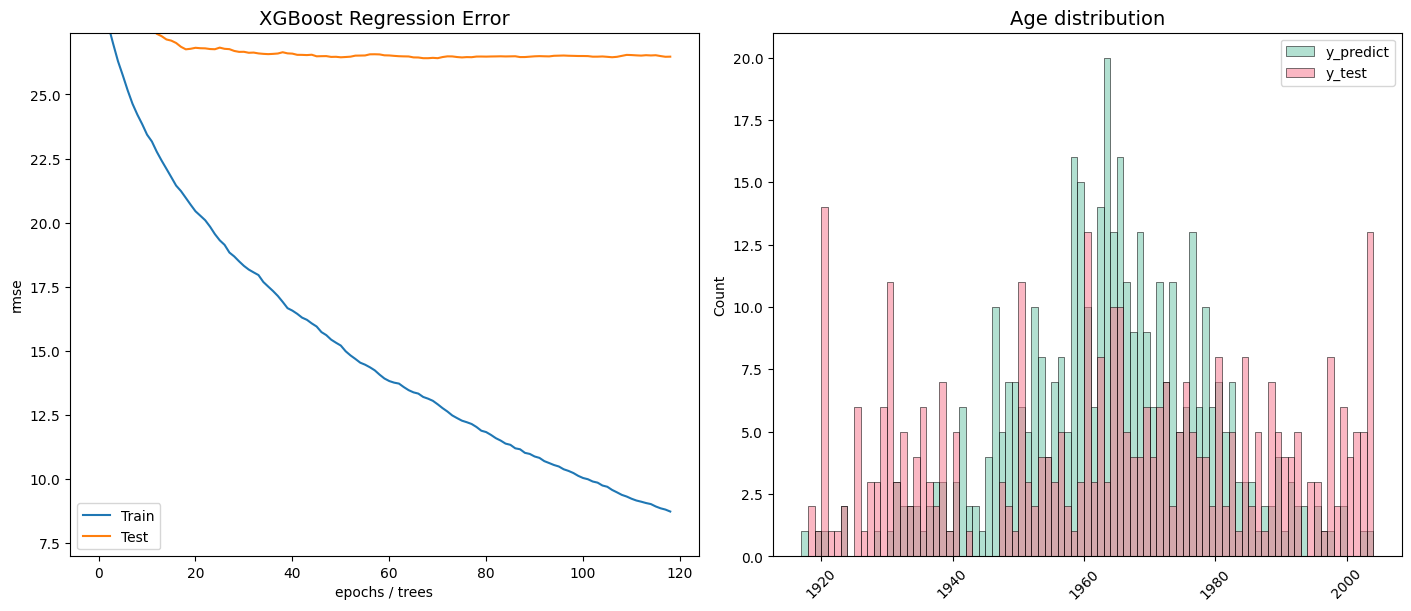

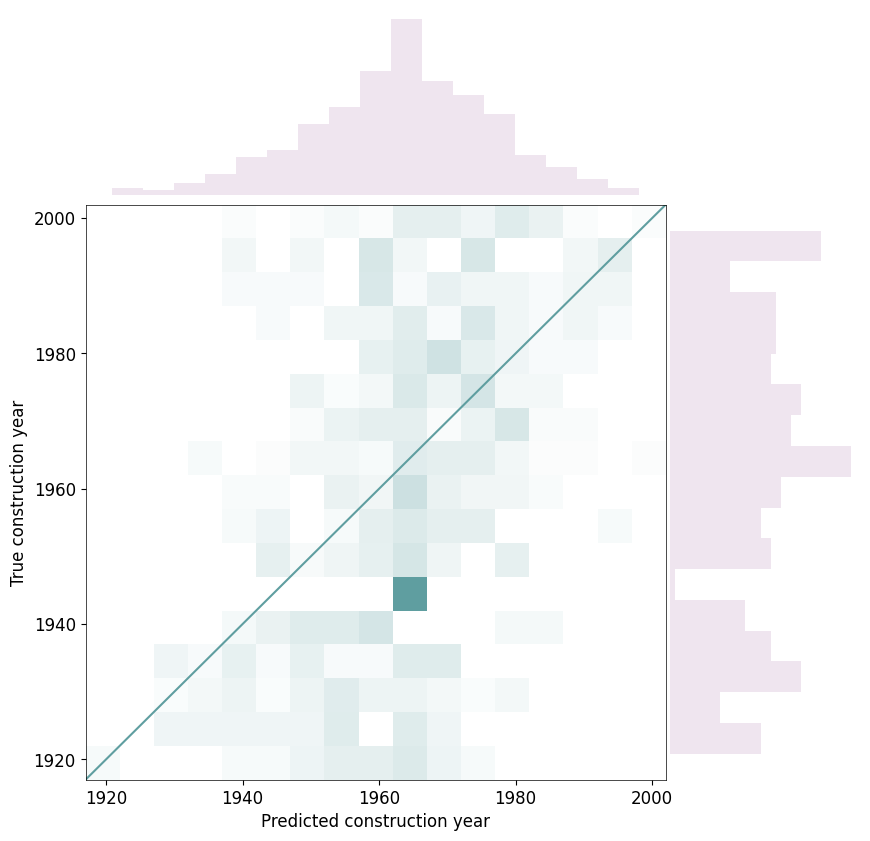

In [9]:
predictor = AgePredictor(
    model=XGBRegressor(**xgb_model_params),
    df=df,
    test_training_split=pp.split_80_20,
    # cross_validation_split=pp.cross_validation,
    early_stopping=True,
    hyperparameters=xgb_hyperparams,
    # preprocessing_stages=[pp.remove_outliers, pp.categorical_to_int_byList, pp.convert_to_double_byList]
    preprocessing_stages=[pp.remove_outliers]
)

predictor.evaluate()


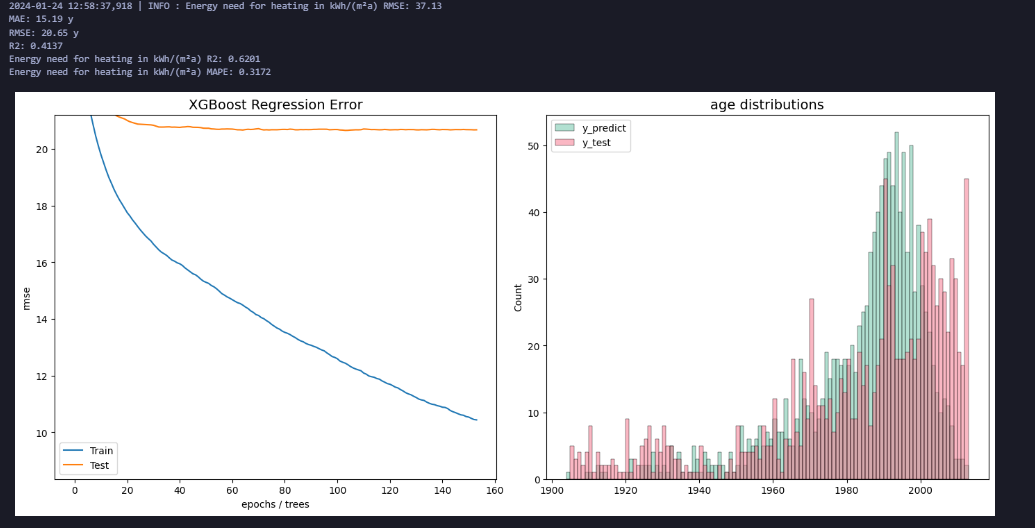
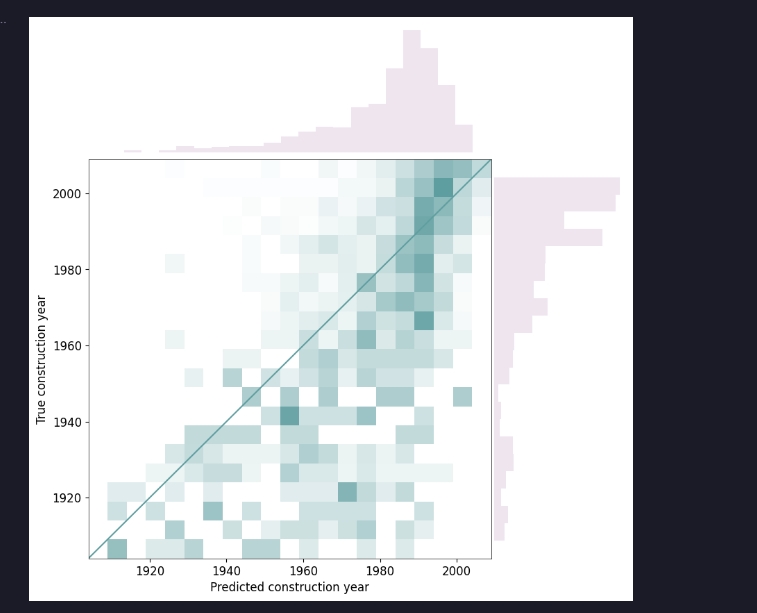

### Classification

2024-04-15 20:13:04,863 | INFO : Generated bins: [1900, 1945, 1970, 1980, 1990, 2000, 2010, 2051]
2024-04-15 20:13:04,864 | INFO : Generated bins with the following labels: ['1900-1944', '1945-1969', '1970-1979', '1980-1989', '1990-1999', '2000-2009', '2010-2050']
2024-04-15 20:13:04,867 | INFO : Dataset length: 2121
2024-04-15 20:13:04,872 | INFO : Dataset allocated memory: 2 MB
2024-04-15 20:13:04,874 | INFO : No abort signal received. Continuing... To abort please create workspace/ufo-prediction/metadata/local-71aca8c9.abort.
2024-04-15 20:13:04,875 | INFO : Training dataset length: 1696
2024-04-15 20:13:04,875 | INFO : Test dataset length: 425
2024-04-15 20:13:04,876 | INFO : Test cities: ['VÃ©lez-MÃ¡laga' 'Sluis' 'Salamanca' 'Sabadell' 'MÃ¡laga (AndalucÃ\xada)'
 'Veere' 'Medio Cudeyo' 'Venlo' 'Reimerswaal' 'Ciudad Rodrigo'
 'Pedrezuela' 'Saint-Symphorien' 'GerbÃ©viller' 'Constantina' 'Madrid'
 'Maastricht' 'Ã\x89trÃ©chy' 'Hengelo (Overijssel)'
 'Saint-Symphorien-sur-Coise' 'Sint-M

Classification report:
               precision    recall  f1-score  support
1900-1944      0.604317  0.661417  0.631579      127
1945-1969      0.398058  0.372727  0.384977      110
1970-1979      0.309091  0.369565  0.336634       46
1980-1989      0.312500  0.227273  0.263158       44
1990-1999      0.250000  0.250000  0.250000       36
2000-2009      0.225000  0.236842  0.230769       38
2010-2050      0.000000  0.000000  0.000000       11
accuracy       0.412621  0.412621  0.412621        0
macro avg      0.299852  0.302546  0.299588      412
weighted avg   0.403041  0.412621  0.406289      412
Cohen’s kappa: 0.2556
Matthews correlation coefficient (MCC): 0.2560


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


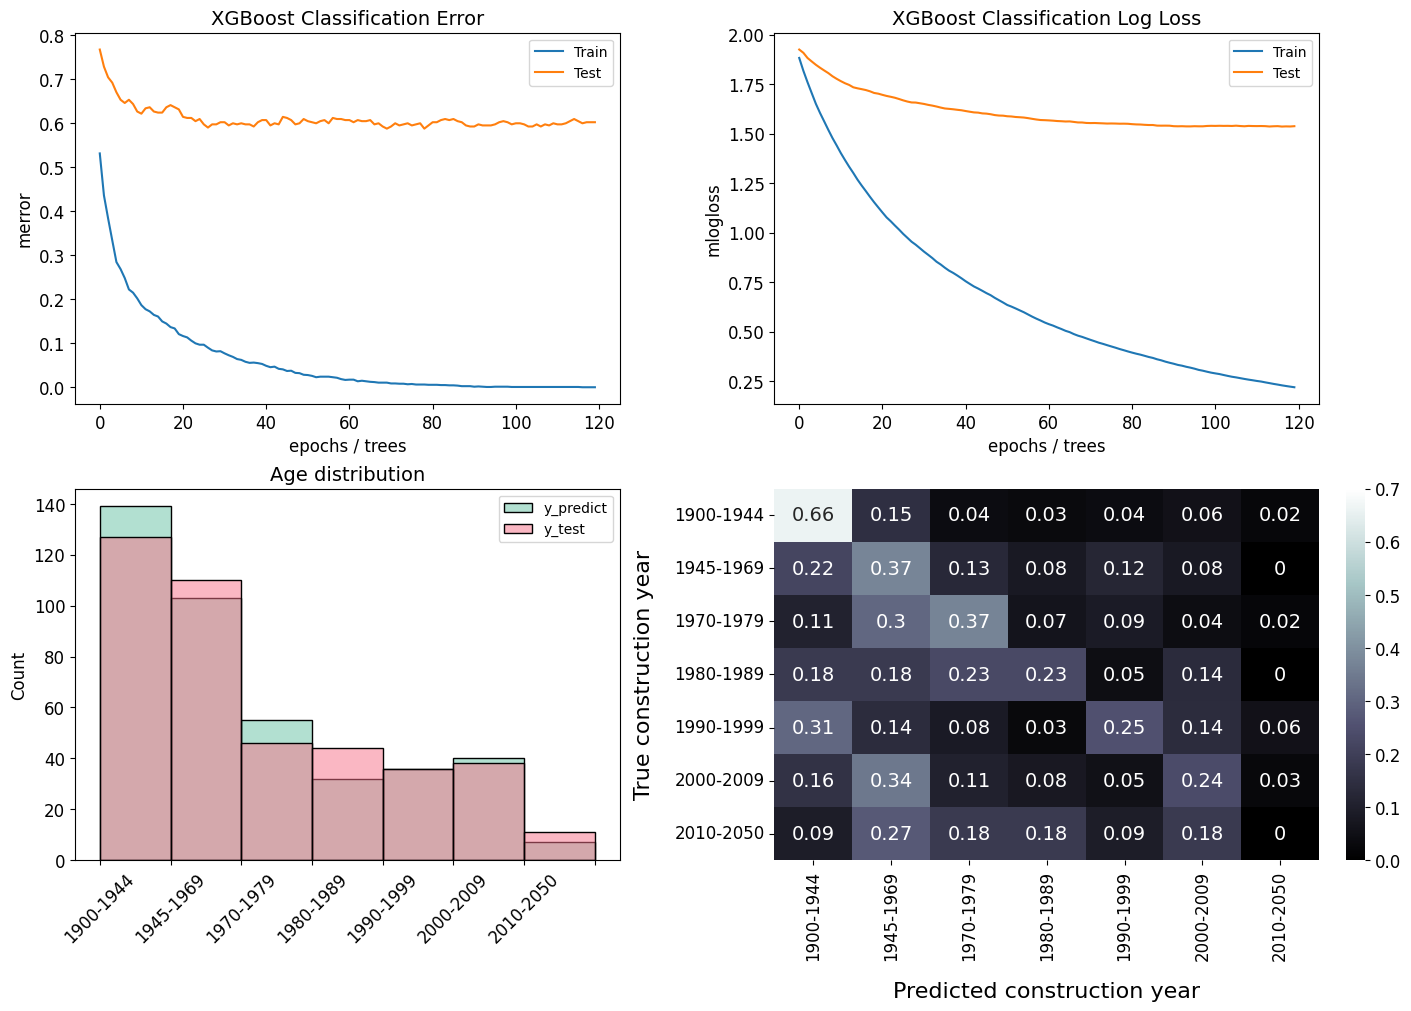

In [10]:
tabula_nl_bins = [1900, 1965, 1975, 1992, 2006, 2015, 2022]
equally_sized_bins = [1900, 1945, 1970, 1980, 1990, 2000, 2010, 2051]

classifier = AgeClassifier(
    model=XGBClassifier(**xgb_model_params),
    df=df,
    test_training_split=pp.split_80_20,
    # cross_validation_split=pp.cross_validation,
    preprocessing_stages=[pp.remove_outliers],
    hyperparameters=xgb_hyperparams,
    mitigate_class_imbalance=True,
    # bin_config=equally_sized_bins,
    bins=equally_sized_bins,
)
classifier.evaluate(vmax=0.7)

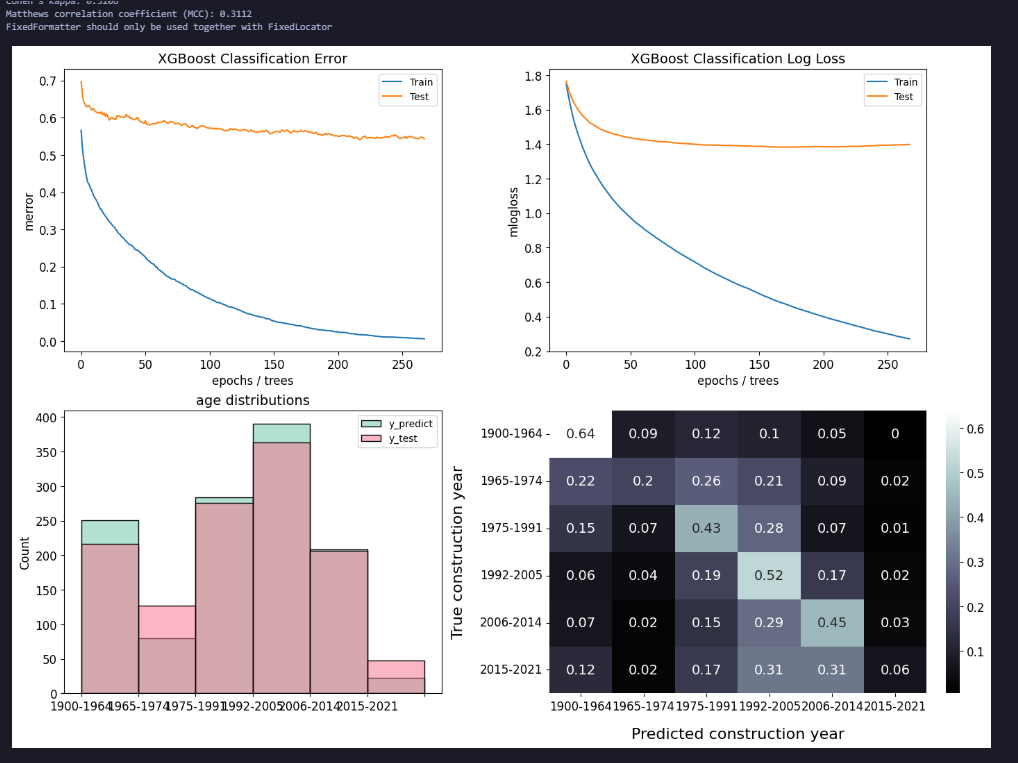

### Country and generalization comparison

The `AgePredictorComparison` faciliates comparisons between differently configured training runs, for example to compare the prediction performance between countries, cross-validation strategies, oversampling strategies or any other preprocessing steps.

In [21]:
comparison_config = {
    'Spain': {'df': path_data_ESP},
    'France': {'df': path_data_FRA},
    'Netherlands': {'df': path_data_NLD},
}

grid_comparison_config = {
    'random-cv': {'cross_validation_split': pp.cross_validation},
    'neighborhood-cv': {'cross_validation_split': pp.neighborhood_cross_validation},
    'city-cv': {'cross_validation_split': pp.city_cross_validation},
}

comparison = AgePredictorComparison(
    exp_name='demo',
    model=XGBRegressor(**xgb_model_params),
    df=None,
    frac=0.5,
    cross_validation_split=None,
    preprocessing_stages=[pp.remove_outliers],
    hyperparameters=xgb_hyperparams,
    compare_feature_importance=False,
    compare_classification_error=False,
    include_baseline=False,
    save_results=False,
    garbage_collect_after_training=True,
    comparison_config=comparison_config,
    grid_comparison_config=grid_comparison_config,
)

results = comparison.evaluate()

2024-01-17 14:50:47,195 | INFO : Starting experiment Spain_random-cv...


2024-01-17 14:53:18,314 | INFO : Dataset length: 4226188
2024-01-17 14:53:18,319 | INFO : Dataset allocated memory: 4385 MB
2024-01-17 14:53:20,237 | INFO : No abort signal received. Continuing... To abort please create /p/projects/eubucco/data/3-ml-inputs/local-33f2404e.abort.
2024-01-17 14:53:20,256 | INFO : Dataset standard deviation: 48.35942318636823
2024-01-17 14:53:20,263 | INFO : Dataset mean age: 1971.7313162594755
2024-01-17 14:53:20,264 | INFO : Training dataset length: 3380950
2024-01-17 14:53:20,264 | INFO : Test dataset length: 845238
2024-01-17 14:53:33,818 | INFO : Test dataset standard deviation after preprocessing: 25.909066171213233
2024-01-17 14:53:33,820 | INFO : Test dataset mean age after preprocessing: 1980.6306878251494
2024-01-17 14:53:33,821 | INFO : Training dataset length after preprocessing: 3058384
2024-01-17 14:53:33,821 | INFO : Test dataset length after preprocessing: 764264
`early_stopping_rounds` in `fit` method is deprecated for better compatibility

FileNotFoundError: [Errno 2] No such file or directory: '/workspace/workspace/ufo-prediction/demo/df-FRA.pkl'

In [ ]:
results

,name,R2,R2_std,MAE,MAE_std,RMSE,RMSE_std,within_5_years,within_10_years,within_20_years,R2_seed_0
8,Netherlands_city-cv,0.135401,0.0,18.030643,0.0,23.598668,0.0,0.221385,0.392977,0.638903,0.135401
7,France_city-cv,0.187767,0.0,18.645831,0.0,23.772030,0.0,0.176875,0.345911,0.615315,0.187767
6,Spain_city-cv,0.197072,0.0,23.840955,0.0,29.563272,0.0,0.126411,0.247178,0.494357,0.197072
3,Spain_neighborhood-cv,0.198503,0.0,23.779078,0.0,29.536916,0.0,0.129797,0.247178,0.506772,0.198503
5,Netherlands_neighborhood-cv,0.304538,0.0,15.884060,0.0,21.164937,0.0,0.241489,0.444702,0.699700,0.304538
4,France_neighborhood-cv,0.330228,0.0,16.306574,0.0,21.586864,0.0,0.211348,0.408337,0.705209,0.330228
0,Spain_random-cv,0.363164,0.0,20.108252,0.0,26.328608,0.0,0.180587,0.355530,0.592551,0.363164
1,France_random-cv,0.511105,0.0,12.372172,0.0,18.443089,0.0,0.369564,0.593466,0.806340,0.511105
2,Netherlands_random-cv,0.575725,0.0,10.203823,0.0,16.531180,0.0,0.525335,0.695626,0.827052,0.575725


In [ ]:
del comparison, predictor, classifier, results, df, df_temp, df_temp2, df_dropped
gc.collect()